Spectral Ratio Meditation analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
 # Smoothing function
def smooth_curve_simple(x, y, points=300):
    x_new = np.linspace(min(x), max(x), points)
    spl = make_interp_spline(x, y, k=2)
    y_new = spl(x_new)
    return x_new, y_new

In [4]:
# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define channels and sampling frequency
channels = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
sampling_frequency = 256


In [20]:
# Fully working consolidated code - FINAL
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

channels = ['RAW_TP9', 'RAW_TP10']
time_power = {}
time_intervals = ['First 33%', 'Middle 33%', 'Last 33%']
    # Define frequency bands
band_ranges = {
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Delta': (0.5, 4),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }

# Filter the data
def analyse_EEG(file_path):
    df = pd.read_csv(file_path)
    df = df[channels]
    df = df.dropna()
    filtered_df = df.copy()
    for channel in channels:
        filtered_df[channel] = bandpass_filter(df[channel], 0.5, 45, sampling_frequency)

    # Handle NaNs and Infinite values
    filtered_df = filtered_df.fillna(filtered_df.mean())
    filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Apply ICA
    ica = FastICA(n_components=4, random_state=97, max_iter=800)
    ICAfit = ica.fit_transform(filtered_df[channels])

    # Convert the ICA components back to the original space
    df_cleaned = df.copy()
    df_cleaned[channels] = ica.inverse_transform(ICAfit)


    # Fourier transform for power spectra
    frequencies = np.fft.fftfreq(df_cleaned.shape[0], 1/sampling_frequency)
    band_power = {}

    for channel in channels:
        fft_values = fft(df_cleaned[channel].values)
        power_spectrum = np.abs(fft_values)**2
        band_power[channel] = {}
        for band, (low_freq, high_freq) in band_ranges.items():
            idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))
            avg_power = np.mean(power_spectrum[idx_band])
            band_power[channel][band] = avg_power

    # Temporal analysis
    split_indices = np.array_split(df_cleaned.index, 3)

    for i, interval in enumerate(time_intervals):
        time_power[interval] = {}
        df_interval = df_cleaned.loc[split_indices[i]]
        interval_power_spectra = {}
        for channel in channels:
            fft_values = fft(df_interval[channel].values)
            power_spectrum = np.abs(fft_values)**2
            interval_power_spectra[channel] = power_spectrum

        for channel in channels:
            time_power[interval][channel] = {}
            for band, (low_freq, high_freq) in band_ranges.items():
                idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))
                avg_power = np.mean(interval_power_spectra[channel][idx_band])
                time_power[interval][channel][band] = avg_power

    # Attention metrics
    attention_metrics = {}
    for interval in time_intervals:
        attention_metrics[interval] = {}
        for channel in channels:
            theta_power = time_power[interval][channel]['Theta']
            beta_power = time_power[interval][channel]['Beta']
            alpha_power = time_power[interval][channel]['Alpha']
            gamma_power = time_power[interval][channel]['Gamma']
            tbr = theta_power / beta_power if beta_power != 0 else 0
            attention_metrics[interval][channel] = {
                'Theta/Beta Ratio': tbr,
                'Alpha Power': alpha_power,
                'Gamma Power': gamma_power
            }

    # Aggregate metrics
    aggregated_metrics = {}
    for interval in time_intervals:
        aggregated_metrics[interval] = {
            'Theta/Beta Ratio': 0,
            'Alpha Power': 0,
            'Gamma Power': 0
        }
        for channel in channels:
            aggregated_metrics[interval]['Theta/Beta Ratio'] += attention_metrics[interval][channel]['Theta/Beta Ratio']
            aggregated_metrics[interval]['Alpha Power'] += attention_metrics[interval][channel]['Alpha Power']
            aggregated_metrics[interval]['Gamma Power'] += attention_metrics[interval][channel]['Gamma Power']

        aggregated_metrics[interval]['Theta/Beta Ratio'] /= len(channels)
        aggregated_metrics[interval]['Alpha Power'] /= len(channels)
        aggregated_metrics[interval]['Gamma Power'] /= len(channels)

    # Update the aggregated metrics
    for interval in time_intervals:
        theta_power = np.mean([time_power[interval][channel]['Theta'] for channel in channels])
        beta_power = np.mean([time_power[interval][channel]['Beta'] for channel in channels])
        alpha_power = np.mean([time_power[interval][channel]['Alpha'] for channel in channels])
        delta_power = np.mean([time_power[interval][channel]['Delta'] for channel in channels])
        gamma_power = np.mean([time_power[interval][channel]['Gamma'] for channel in channels])

        aggregated_metrics[interval]['Theta/Beta Ratio'] = theta_power / (beta_power + 1e-6)
        aggregated_metrics[interval]['Theta/Alpha Ratio'] = theta_power / (alpha_power + 1e-6)
        aggregated_metrics[interval]['Delta/Theta Ratio'] = delta_power / (theta_power + 1e-6)
        aggregated_metrics[interval]['Theta/Gamma Ratio'] = theta_power / (gamma_power + 1e-6)

    return {
        'band_power': band_power,
        'time_power': time_power,
        'attention_metrics': attention_metrics,
        'aggregated_metrics': aggregated_metrics
    }

# Loop over data for all 15 people
all_results = {}
for i in range(1, 16):  # Assuming 15 people
    EEG = f"/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/Meditation/{i}_Med.csv"
    all_results[f"person_{i}"] = analyse_EEG(EEG)

print(all_results)

{'person_1': {'band_power': {'RAW_TP9': {'Theta': 617683321.1801082, 'Alpha': 202702870.38427836, 'Delta': 2816166821.4379616, 'Beta': 59398436.02631445, 'Gamma': 17916391.719455224}, 'RAW_TP10': {'Theta': 1335897671.2151306, 'Alpha': 633084320.1264645, 'Delta': 4762929641.34492, 'Beta': 146483247.42222497, 'Gamma': 30619017.994142924}}, 'time_power': {'First 33%': {'RAW_TP9': {'Theta': 23883380.985789187, 'Alpha': 13948529.789858771, 'Delta': 77756536.88968393, 'Beta': 2441518.9621057427, 'Gamma': 178.3246831823937}, 'RAW_TP10': {'Theta': 29648091.911768865, 'Alpha': 14554334.136208318, 'Delta': 81248263.10178022, 'Beta': 1043859.5784923364, 'Gamma': 0.9818535091904742}}, 'Middle 33%': {'RAW_TP9': {'Theta': 20393424.42186469, 'Alpha': 9350953.674319442, 'Delta': 63542858.435935274, 'Beta': 1840648.8374502761, 'Gamma': 3.418527965430055}, 'RAW_TP10': {'Theta': 27871058.995611623, 'Alpha': 10303876.722204965, 'Delta': 64735911.064996205, 'Beta': 729689.1613773503, 'Gamma': 5.76530419927

In [21]:
df=pd.DataFrame(all_results)

In [8]:
df.to_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results.csv")


In [19]:
df.to_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_resultsfromtals.csv")


In [22]:
df.to_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_resultstemporal.csv")


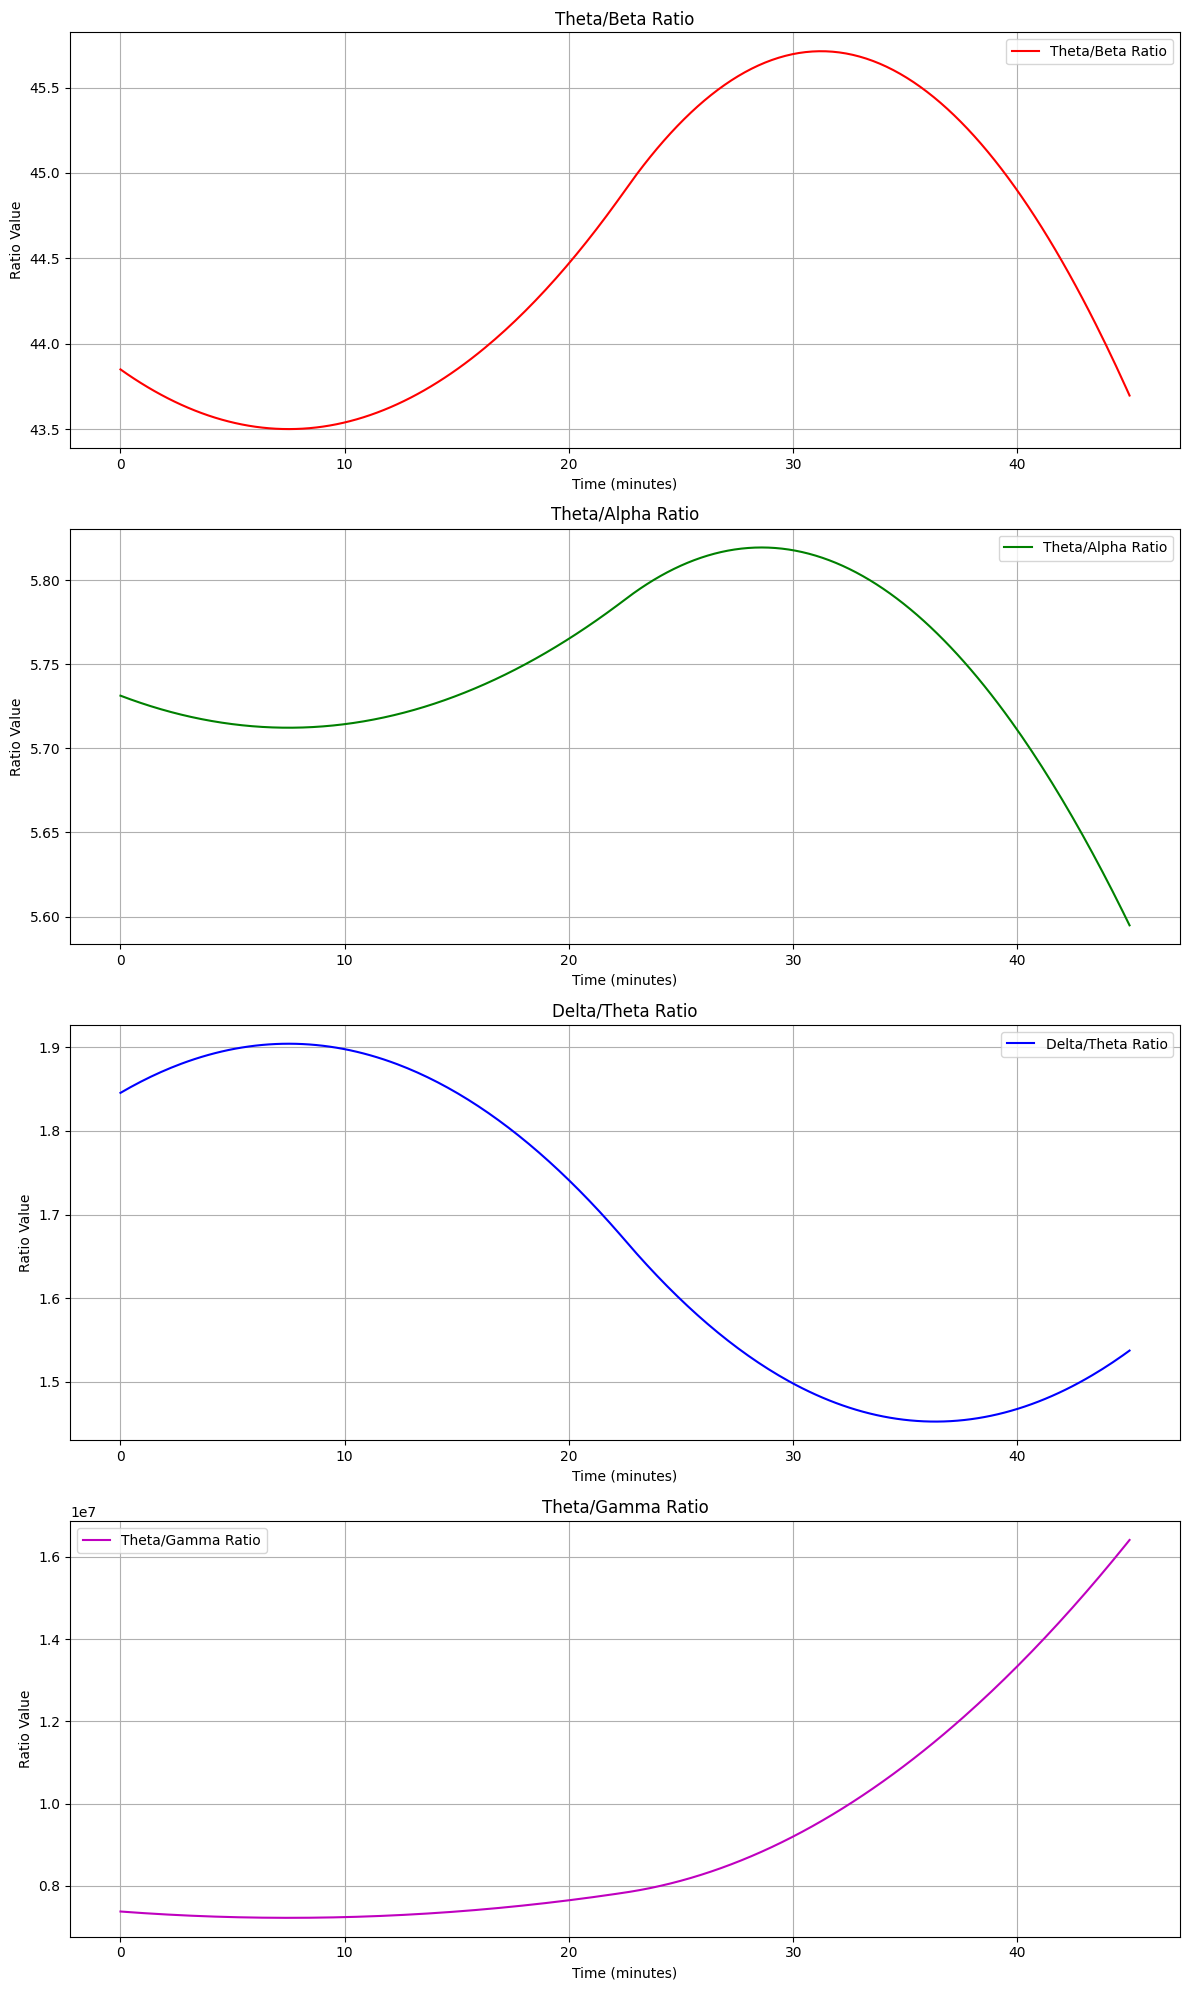

'/mnt/data/smoothed_ratios_consolidated.csv'

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import ast

ratios = ['Theta/Beta Ratio', 'Theta/Alpha Ratio', 'Delta/Theta Ratio', 'Theta/Gamma Ratio']
time_intervals = ['First 33%', 'Middle 33%', 'Last 33%']

# Extracting aggregated metrics for all participants
all_data = {}
for col in df.columns:
    metrics = df.loc[df.index[3], col]
    if isinstance(metrics, str):  # Check if it's a serialized string
        metrics = ast.literal_eval(metrics)
    all_data[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants
avg_data = {}
for ratio in ratios:
    avg_data[ratio] = [np.mean([all_data[person][ratio][i] for person in all_data]) for i in range(3)]

# Define time_points for plotting
time_points = [0, 15, 30, 45]

# Adjusted spline interpolation with the new time points
xnew = np.linspace(min(time_points), max(time_points), 300)
avg_data_smooth = {}

# Plotting separate curves for each ratio
fig, axs = plt.subplots(4, 1, figsize=(12, 20))

for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(time_points, [avg_data[ratio][0]] + avg_data[ratio], k=2)  # Include value at time 0
    ynew = spline(xnew)
    avg_data_smooth[ratio] = ynew
    axs[idx].plot(xnew, ynew, label=ratio, color=color)
    axs[idx].set_title(ratio)
    axs[idx].set_xlabel("Time (minutes)")
    axs[idx].set_ylabel("Ratio Value")
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

# # Save the smoothed ratio values to a CSV
# df_ratios_smooth = pd.DataFrame(avg_data_smooth)
# df_ratios_smooth['Time (minutes)'] = xnew
# df_ratios_smooth.to_csv("medratios", index=False)

In [23]:
# Consolidating the percentage shifts for frontal and temporal analysis

# Frontal values
frontal_TBR_shift = [4.21, -4.37]
frontal_TAR_shift = [1.51, -3.83]
frontal_DTR_shift = [-18.81, 2.63]
frontal_TGR_shift = [2.47, 7.84]

# Temporal values
temporal_TBR_shift = [0.56, -5.11]
temporal_TAR_shift = [-5.68, -3.63]
temporal_DTR_shift = [-27.41, 21.88]
temporal_TGR_shift = [471.95, -68.91]

# Creating a consolidated table
table_data = {
    "Brain Region": ["Frontal", "Frontal", "Temporal", "Temporal"],
    "Stages": ["Analyzing challenges", "Rehearsing solutions", "Analyzing challenges", "Rehearsing solutions"],
    "Theta/Beta Ratio (TBR)": frontal_TBR_shift + temporal_TBR_shift,
    "Theta/Alpha Ratio (TAR)": frontal_TAR_shift + temporal_TAR_shift,
    "Delta/Theta Ratio (DTR)": frontal_DTR_shift + temporal_DTR_shift,
    "Theta/Gamma Ratio (TGR)": frontal_TGR_shift + temporal_TGR_shift
}

df_shifts = pd.DataFrame(table_data)
df_shifts


,Brain Region,Stages,Theta/Beta Ratio (TBR),Theta/Alpha Ratio (TAR),Delta/Theta Ratio (DTR),Theta/Gamma Ratio (TGR)
0,Frontal,Analyzing challenges,4.21,1.51,-18.81,2.47
1,Frontal,Rehearsing solutions,-4.37,-3.83,2.63,7.84
2,Temporal,Analyzing challenges,0.56,-5.68,-27.41,471.95
3,Temporal,Rehearsing solutions,-5.11,-3.63,21.88,-68.91
